# I. Random Graph Model Testing

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import logging
logging.captureWarnings(True) # Logging warnings in order to suppress them

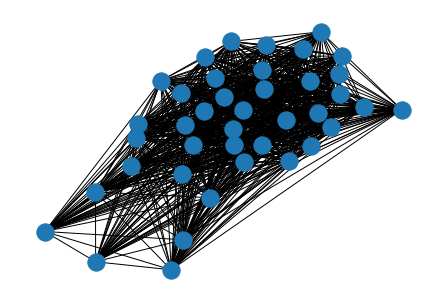

In [9]:
# For this task use the full weight matrix V.
V = nx.Graph(np.genfromtxt("data/sgb128Nodes41to80_weight.txt", delimiter=' ', skip_header=1))
nx.draw(V)